In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
## data from R library 'billboard'

In [3]:
df = pd.read_csv('songs4.csv')
df.head(10)

,acousticness,artist,audio_mode,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,no,speechiness,tempo,time_signature,title,type,valence,year
0,0.909,Jim Reeves,NaN,0.554,138640,0.186,0.001440,1,0.110,-15.846,1.0,2,0.0379,81.181,3,He'll Have to Go,Top10,0.200,1960
1,0.790,Johnny Preston,NaN,0.758,160027,0.462,0.000013,5,0.170,-8.952,0.0,4,0.0482,120.004,4,Running Bear,Top10,0.726,1960
2,0.869,Mark Dinning,NaN,0.583,157080,0.168,0.000000,0,0.148,-12.426,1.0,5,0.0350,97.572,4,Teen Angel,Top10,0.353,1960
3,0.649,Jimmy Jones,NaN,0.534,120973,0.720,0.000000,10,0.258,-7.679,1.0,8,0.0395,74.207,4,Handy Man,Top10,0.901,1960
4,0.811,Elvis Presley,NaN,0.664,139293,0.539,0.000691,7,0.156,-11.781,1.0,9,0.0408,132.212,4,Stuck on You,Top10,0.946,1960
5,0.792,Connie Francis,NaN,0.587,160093,0.720,0.000015,1,0.255,-5.214,1.0,11,0.0303,84.272,4,Everybody's Somebody's Fool,Other,0.806,1960
6,0.852,The Brothers Four,NaN,0.485,183360,0.182,0.000000,11,0.112,-18.083,0.0,13,0.0434,110.608,1,Greenfields,Other,0.347,1960
7,0.835,Marty Robbins,NaN,0.654,259307,0.452,0.000029,2,0.160,-9.709,1.0,15,0.0300,106.662,3,El Paso,Other,0.697,1960
8,0.865,Connie Stevens,NaN,0.339,118133,0.406,0.000011,10,0.110,-8.955,1.0,22,0.0319,109.783,3,Sixteen Reasons,Other,0.629,1960
9,0.297,Paul Anka,NaN,0.346,168200,0.348,0.000575,7,0.334,-13.336,1.0,23,0.0308,101.527,3,Puppy Love,Other,0.631,1960


In [4]:
df.shape

(2840, 19)

In [5]:
df.columns

Index(['acousticness', 'artist', 'audio_mode', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'no', 'speechiness', 'tempo', 'time_signature', 'title', 'type',
       'valence', 'year'],
      dtype='object')

In [6]:
df.isnull().sum()

acousticness           0
artist                 0
audio_mode          2558
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                 282
no                     0
speechiness            0
tempo                  0
time_signature         0
title                  0
type                   0
valence                0
year                   0
dtype: int64

In [7]:
df.dtypes

acousticness        float64
artist               object
audio_mode          float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                float64
no                    int64
speechiness         float64
tempo               float64
time_signature        int64
title                object
type                 object
valence             float64
year                  int64
dtype: object

In [8]:
df.type.value_counts()

Other    2528
Top10     312
Name: type, dtype: int64

## Create a categorical column for future classification

In [9]:
# define the function to convert no into category
def billboard_rank(rank):
    if rank > 10:
        return 'Other'
    else:
        return 'Top10'

## EDA

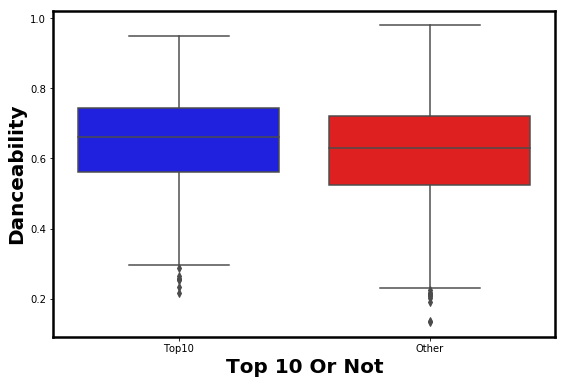

In [10]:
my_pal = {"Other": "r", "Top10": "b"}
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.boxplot(x="type", y="danceability", data= df, palette=my_pal)
plt.xlabel('Top 10 Or Not',weight = 'bold',size =20)
plt.ylabel('Danceability',weight = 'bold',size =20)

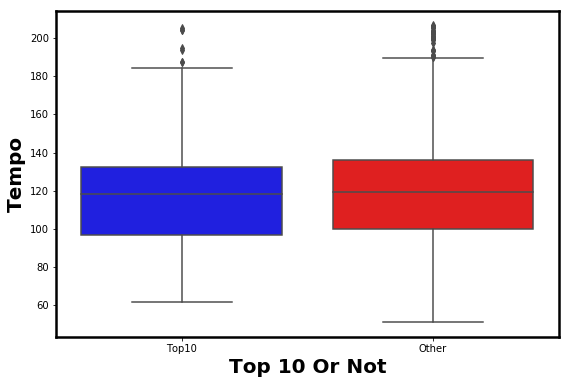

In [11]:
my_pal = {"Other": "r", "Top10": "b"}
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.boxplot(x="type", y="tempo", data= df, palette=my_pal)
plt.xlabel('Top 10 Or Not',weight = 'bold',size =20)
plt.ylabel('Tempo',weight = 'bold',size =20)

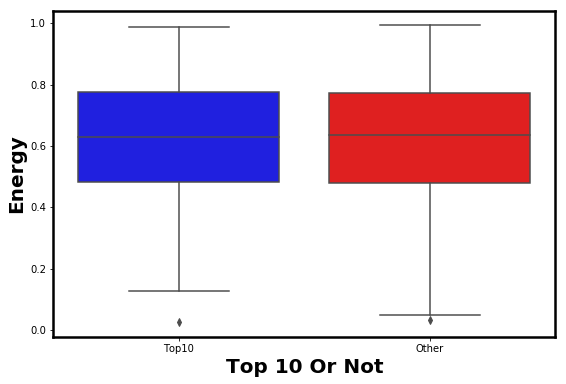

In [12]:
my_pal = {"Other": "r", "Top10": "b"}
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.boxplot(x="type", y="energy", data= df, palette=my_pal)
plt.xlabel('Top 10 Or Not',weight = 'bold',size =20)
plt.ylabel('Energy',weight = 'bold',size =20)

## Preliminary Classification

In [13]:
predictors = [ 'danceability','energy', 'instrumentalness', 'key', 'liveness', 'loudness','speechiness',
               'tempo']

X = df[predictors]
y = df.type

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2272, 8) (2272,)
(568, 8) (568,)


In [15]:
# Logistic Regression for prediction
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.88


In [16]:
# Try optimizing Logistic Regression model
#the grid of parameters to search over
Cs = [0.001,0.01, 0.1, 1, 10, 100]

Scores = []

for item in Cs:
    clf = LogisticRegression(C=item)
    clf.fit(X_train, y_train)
    Scores.append((clf.score(X_test, y_test)))
    
Scores

[0.88028169014084512,
 0.88028169014084512,
 0.88028169014084512,
 0.88028169014084512,
 0.88028169014084512,
 0.88028169014084512]

In [17]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 

# print knn score
print("Score: {:.2f}".format(knn.score(X_test, y_test)))

Score: 0.87


In [18]:
training_accuracy = []
test_accuracy = []
# We define a range of 1 to 10 (included) neighbors that will be tested
neighbors_settings = range(3,21,2)

# We loop the KNN model through the range of possible neighbors to evaluate which one would be 
# appropriate for this analysis

for n_neighbors in neighbors_settings:
    print(n_neighbors)
    # creating the KNN classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    # fitting the model
    clf.fit(X_train, y_train)
    #recording the accuracy of the training set
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
    #recording the accuracy of the test set
    print(clf.score(X_test, y_test))
    print()

3
0.841549295775

5
0.869718309859

7
0.880281690141

9
0.878521126761

11
0.880281690141

13
0.880281690141

15
0.880281690141

17
0.880281690141

19
0.880281690141



In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train,y_train)
# print Gaussian Naive Bayes score
print("Score: {:.2f}".format(gnb.score(X_test, y_test)))

Score: 0.83


In [20]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Score: {:.2f}".format(dtc.score(X_test, y_test)))

Score: 0.80
